# Model Training

We train a RandomForest/XGBoost model to predict the outcome of job applications based on features engineered.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

### Split, Scale and Transform Data

In [2]:
data = pd.read_pickle("../data/final_resume_screening_dataset.pkl")
data

,Decision,Resume_JD_Sim,Role_Resume_Sim,Word_Overlap,Tech_Keyword_Overlap
0,reject,0.505354,0.646826,0.298246,0.250000
1,select,0.411644,0.502842,0.069767,0.000000
2,reject,0.604468,0.587193,0.269504,0.000000
3,select,0.351232,0.512997,0.231579,0.250000
4,reject,0.428203,0.641594,0.300885,0.333333
...,...,...,...,...,...
10169,reject,0.435778,0.481033,0.276596,0.000000
10170,reject,0.367484,0.471639,0.362637,0.625000
10171,select,0.459990,0.501841,0.337079,0.375000
10172,reject,0.403455,0.499404,0.386667,0.666667


In [3]:
features = data.drop("Decision", axis=1)
target = data["Decision"]
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=42,
    stratify=target)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8139, 4), (2035, 4), (8139,), (2035,))

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((8139, 4), (2035, 4))

In [6]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features.columns)
X_train_scaled

,Resume_JD_Sim,Role_Resume_Sim,Word_Overlap,Tech_Keyword_Overlap
0,-1.670956,-1.867215,0.387994,-0.070057
1,-0.844068,0.467805,1.494236,1.224370
2,-0.071380,-0.513670,-2.513432,-2.011696
3,-0.206470,0.340776,1.856387,0.577157
4,-0.689805,-0.498421,-0.061932,0.318271
...,...,...,...,...
8134,1.516016,1.396946,-0.886951,0.900763
8135,0.618050,0.114982,0.052920,0.415353
8136,1.502043,0.120172,0.946226,-0.070057
8137,-0.419490,0.296750,1.704693,0.318271


In [7]:
X_test_scaled

,Resume_JD_Sim,Role_Resume_Sim,Word_Overlap,Tech_Keyword_Overlap
0,1.094691,0.987202,0.543006,0.207321
1,-0.501260,0.049356,0.196265,-0.458384
2,-0.668426,1.426382,-0.419016,-0.458384
3,1.359715,1.263698,-1.273116,-0.458384
4,0.757466,1.188246,0.039339,0.900763
...,...,...,...,...
2030,-0.702567,0.802261,1.065022,0.318271
2031,0.379133,-1.157327,0.966984,-0.458384
2032,-0.134354,0.841110,2.526774,1.871583
2033,2.040447,1.495978,-1.305433,-0.070057


### Initialize Model

In [8]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees
    'max_depth': [5, 10, 15],              # Maximum depth of each tree
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True, 
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'max_depth': 5, 'n_estimators': 200}
Best Cross-Validation Score: 0.5412205578769806


### Plot Training Graph

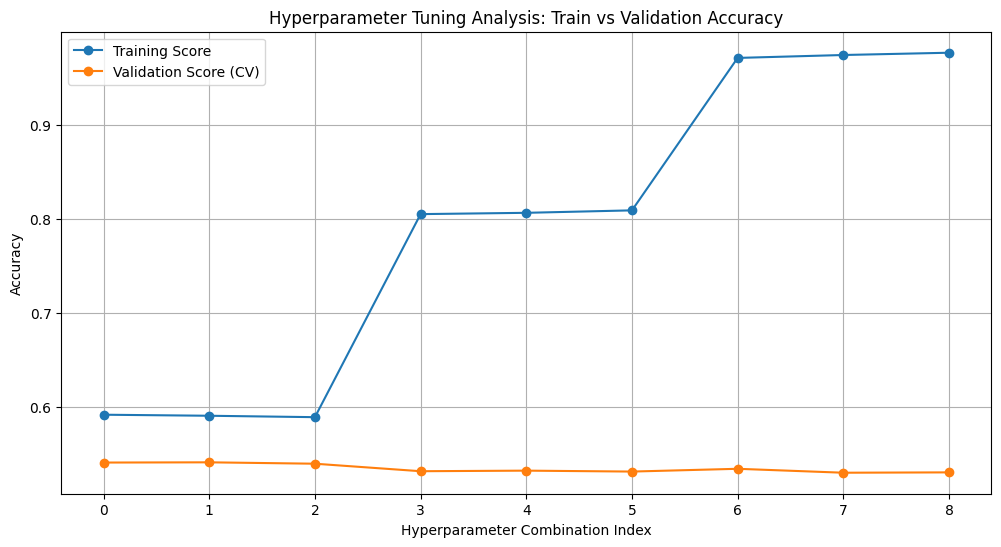

--- Final Test Set Metrics ---
Accuracy: 0.5499
              precision    recall  f1-score   support

      reject       0.54      0.65      0.59      1023
      select       0.56      0.45      0.50      1012

    accuracy                           0.55      2035
   macro avg       0.55      0.55      0.54      2035
weighted avg       0.55      0.55      0.55      2035



In [9]:
# Extract results
results = pd.DataFrame(grid_search.cv_results_)

# Plotting
plt.figure(figsize=(12, 6))

# We plot the mean score for each hyperparameter combination trial
plt.plot(results.index, results['mean_train_score'], label='Training Score', marker='o')
plt.plot(results.index, results['mean_test_score'], label='Validation Score (CV)', marker='o')

plt.title('Hyperparameter Tuning Analysis: Train vs Validation Accuracy')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Quick Evaluation on Test Set
y_pred = best_rf.predict(X_test_scaled)
print("--- Final Test Set Metrics ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred))

Poor performance. Let's try XGBoost.

In [10]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200],      # Number of boosting rounds
    'max_depth': [3, 5, 7],          # Maximum tree depth for base learners
    'learning_rate': [0.01, 0.1],    # Step size shrinkage
    'subsample': [0.8, 1.0],        # Subsample ratio of the training instances
    'scale_pos_weight': [1]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

# Map for xgb
decision_map = {'reject': 0, 'select': 1}
y_train_mapped = y_train.map(decision_map)
y_test_mapped = y_test.map(decision_map)
y_train_mapped
grid_search.fit(X_train_scaled, y_train_mapped)
best_xgb = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1.0}
Best Cross-Validation Score: 0.5398683004399046


c:\Users\msyah\anaconda3\envs\arbyte\lib\site-packages\xgboost\training.py:199: UserWarning: [16:12:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Diagnosis

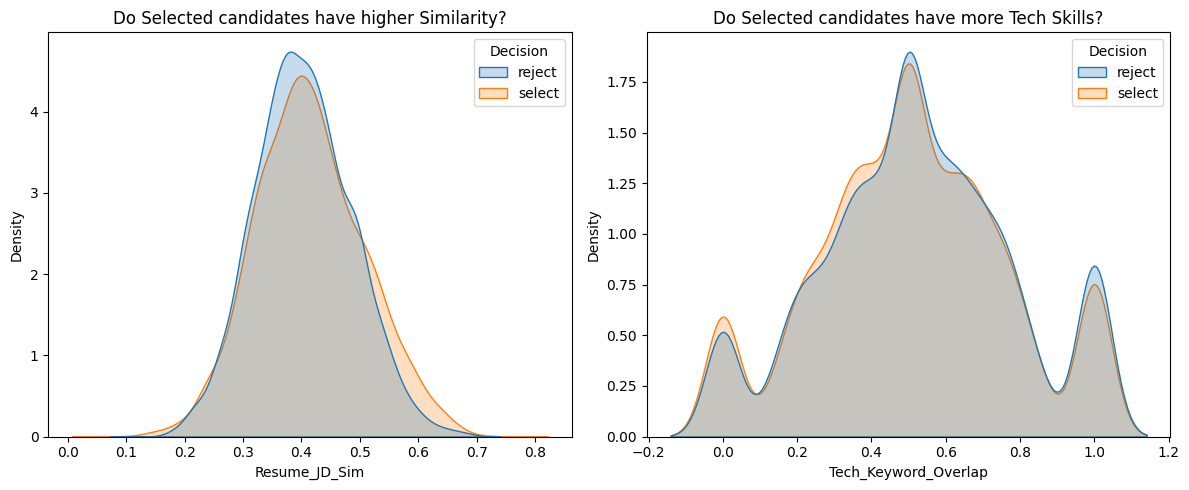

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# We want to see if the "Selected" (Orange) and "Rejected" (Blue) 
# distributions look different or if they sit exactly on top of each other.
plt.figure(figsize=(12, 5))

# Plot Resume_JD_Similarity
plt.subplot(1, 2, 1)
sns.kdeplot(data=data, x='Resume_JD_Sim', hue='Decision', fill=True, common_norm=False)
plt.title("Do Selected candidates have higher Similarity?")

# Plot Tech_Skills_Overlap
plt.subplot(1, 2, 2)
sns.kdeplot(data=data, x='Tech_Keyword_Overlap', hue='Decision', fill=True, common_norm=False)
plt.title("Do Selected candidates have more Tech Skills?")

plt.tight_layout()
plt.show()

### SVM

In [14]:
from sklearn.svm import SVC

# SVM requires scaled data (which you already have in X_train_scaled)
svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)

print("Training SVM...")
svm.fit(X_train_scaled, y_train)

Training SVM...


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [15]:
# Evaluate
print(f"SVM Accuracy: {svm.score(X_test_scaled, y_test):.4f}")

SVM Accuracy: 0.5400


### Multi Layered Perceptron

In [16]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32), # Two layers
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

print("Training Neural Network...")
mlp.fit(X_train_scaled, y_train)

Training Neural Network...


,hidden_layer_sizes,"(64, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True
,random_state,42


In [17]:
# Evaluate
print(f"MLP Accuracy: {mlp.score(X_test_scaled, y_test):.4f}")

MLP Accuracy: 0.5184
